# Summary:
1. The target or price distribution for the test set is quite different from that of training set.
2. But there is a part of training set that matches that distribution pattern.

# Introduction:
After spending so many hours of trying new techniques and ways, being frustrated at myself for not being able to score better on the public leaderboard, despite getting improving my cross validation scores, I set out to probe the inevitable question, WHY?

After analysing and carefully noticing different aspects of my code, I found out that when using 5-Fold cross validation, the 4th fold produces wildy different results thant the other four, and its wildly different score falls in very close proximity to the public leaderboard score.

At first, I thought that it must be the different distributions of features in the validation dataset of 4th fold, that are causing this phenomena, but that wasn't quite the case. Rather, when I plotted the price (target) distribution for the 4th fold, and compared it with the overall train set, as well as to the rest of the folds, I found out the answer to my question, "WHY?". Comes out, the price distribution for the 4th fold's validation set varies quite a bit from the rest. And thus, it is, in my opinion, safe to assume that, that's the price distribution for the test set must be similar to that of fold 4 and hence different from the rest. And that explains the difference wild difference between the cross validation scores and the public leaderboard score.

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from IPython.display import display

In [3]:
from warnings import filterwarnings
filterwarnings("ignore")

# Loading Data

In [4]:
# setting a base path variable for easy access
BASE_PATH = Path("/kaggle/input/playground-series-s3e6")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns=["id"])

test = pd.read_csv(BASE_PATH / "test.csv")
test_idx = test.id
test = test.drop(columns=["id"])

In [5]:
numerical_features = [col for col in train.columns if train[col].nunique() > 20]
# excluding price
numerical_features = numerical_features[:-1]

# Outliers Resolution
This dataset contains quite a lot outliers, as I have shown in this notebook: **[PS3E6 - Hunting Hidden Outliers using Common Sense](https://www.kaggle.com/code/khawajaabaidullah/ps3e6-hunting-hidden-outliers-using-common-sense/)**, and **[PS3E6 - Setting upper bounds may help!](https://www.kaggle.com/code/khawajaabaidullah/ps3e6-setting-upper-bounds-may-help)**
So we'll first resolve them, otherwise our distribution plots will be very skewed.

As taken from **[PS3E6 - Setting upper bounds may help!](https://www.kaggle.com/code/khawajaabaidullah/ps3e6-setting-upper-bounds-may-help)**

In [6]:
for dataset in [train, test]:
    dataset["attic"] = dataset.attic.clip(upper=10000, lower=10)
    dataset["floors"] = dataset.floors.clip(upper=100, lower=1)
    dataset["squareMeters"] = dataset.squareMeters.clip(upper=100000)
    dataset["basement"] = dataset.basement.clip(upper=10000, lower=10)
    dataset["garage"] = dataset.garage.clip(upper=1000, lower=10)
    dataset["cityCode"] = dataset.cityCode.clip(upper=99999)
    dataset["made"] = dataset.made.clip(upper=2021)

As taken from **[PS3E6 - Hunting Hidden Outliers using Common Sense](https://www.kaggle.com/code/khawajaabaidullah/ps3e6-hunting-hidden-outliers-using-common-sense/)**

In [7]:
features_with_outliers = ["garage", "attic", "basement"]

for dataset_name, dataset in zip(["train", "test"], [train, test]):
    print(f"{'-'*30} {dataset_name.upper()} Outliers Resolution {'-'*30}")
    
    for feature in features_with_outliers:
        print(f"\t\t\tRemoving outliers from {feature}...")
        avg_feature_to_house_size_ratio = np.mean(train[feature] / train.squareMeters)
        outliers = dataset[feature] > dataset.squareMeters
        outlier_indices = dataset[outliers].index
        print("BEFORE: ")
        print(f"\tNumber of rows with {feature} size greater than house size: " , len(dataset[outliers]))
        print(f"\tAvg {feature} size of outliers: ", np.mean(dataset[outliers][feature]))

        dataset.loc[outlier_indices, f"{feature}"] = (dataset.loc[outlier_indices].squareMeters * \
                                                      avg_feature_to_house_size_ratio).astype("int64").to_numpy()
        print("AFTER: ")
        print(f"\tNumber of rows with {feature.upper()} size greater than house size: " , len(dataset[dataset[feature] > dataset.squareMeters]))
        print(f"\tAvg {feature.upper()} size of outliers: ", np.mean(dataset[outliers][feature]))
        print("\n")

------------------------------ TRAIN Outliers Resolution ------------------------------
			Removing outliers from garage...
BEFORE: 
	Number of rows with garage size greater than house size:  261
	Avg garage size of outliers:  753.0459770114943
AFTER: 
	Number of rows with GARAGE size greater than house size:  0
	Avg GARAGE size of outliers:  27.50191570881226


			Removing outliers from attic...
BEFORE: 
	Number of rows with attic size greater than house size:  1675
	Avg attic size of outliers:  6723.622089552239
AFTER: 
	Number of rows with ATTIC size greater than house size:  0
	Avg ATTIC size of outliers:  1813.0573134328358


			Removing outliers from basement...
BEFORE: 
	Number of rows with basement size greater than house size:  1660
	Avg basement size of outliers:  6549.134939759037
AFTER: 
	Number of rows with BASEMENT size greater than house size:  0
	Avg BASEMENT size of outliers:  1708.1403614457831


------------------------------ TEST Outliers Resolution ----------------

# Finding dataset part that matches the distribution of test dataset prices

In [8]:
# Note that we won't seprate the target variable since we won't use cross validation for training models
X = train.drop(columns="price")
y = train.price

In [20]:
all_folds_datasets = {}
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, random_state=1337, shuffle=True)
cv_scores = np.zeros(N_FOLDS)

for fold_id, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    fold_data = {"train": X_tr, "train_target": y_tr, 
                 "val": X_val, "val_target": y_val}
    all_folds_datasets["fold_"+str(fold_id+1)] = fold_data
    
    model = xgb.XGBRegressor()
    model.fit(X_tr, y_tr)
    y_preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_preds, squared=False)
    cv_scores[fold_id] = rmse
    
    print(f"Fold {fold_id+1} | RMSE: {rmse}")

avg_rmse = np.mean(cv_scores)
print(f"Average RMSE: {avg_rmse}")

Fold 1 | RMSE: 181522.4536406128
Fold 2 | RMSE: 147356.84209430084
Fold 3 | RMSE: 110622.56447493167
Fold 4 | RMSE: 217357.0894023076
Fold 5 | RMSE: 185447.18265487425
Average RMSE: 168461.22645340546


## INSIGHTS:
While 3rd fold's score is quite significantly **lower** than the rest.

As you can see, the 4th fold's score is quite significantly **higher** than the rest. 

Let's investigate!

In [23]:
len(numerical_features)

8

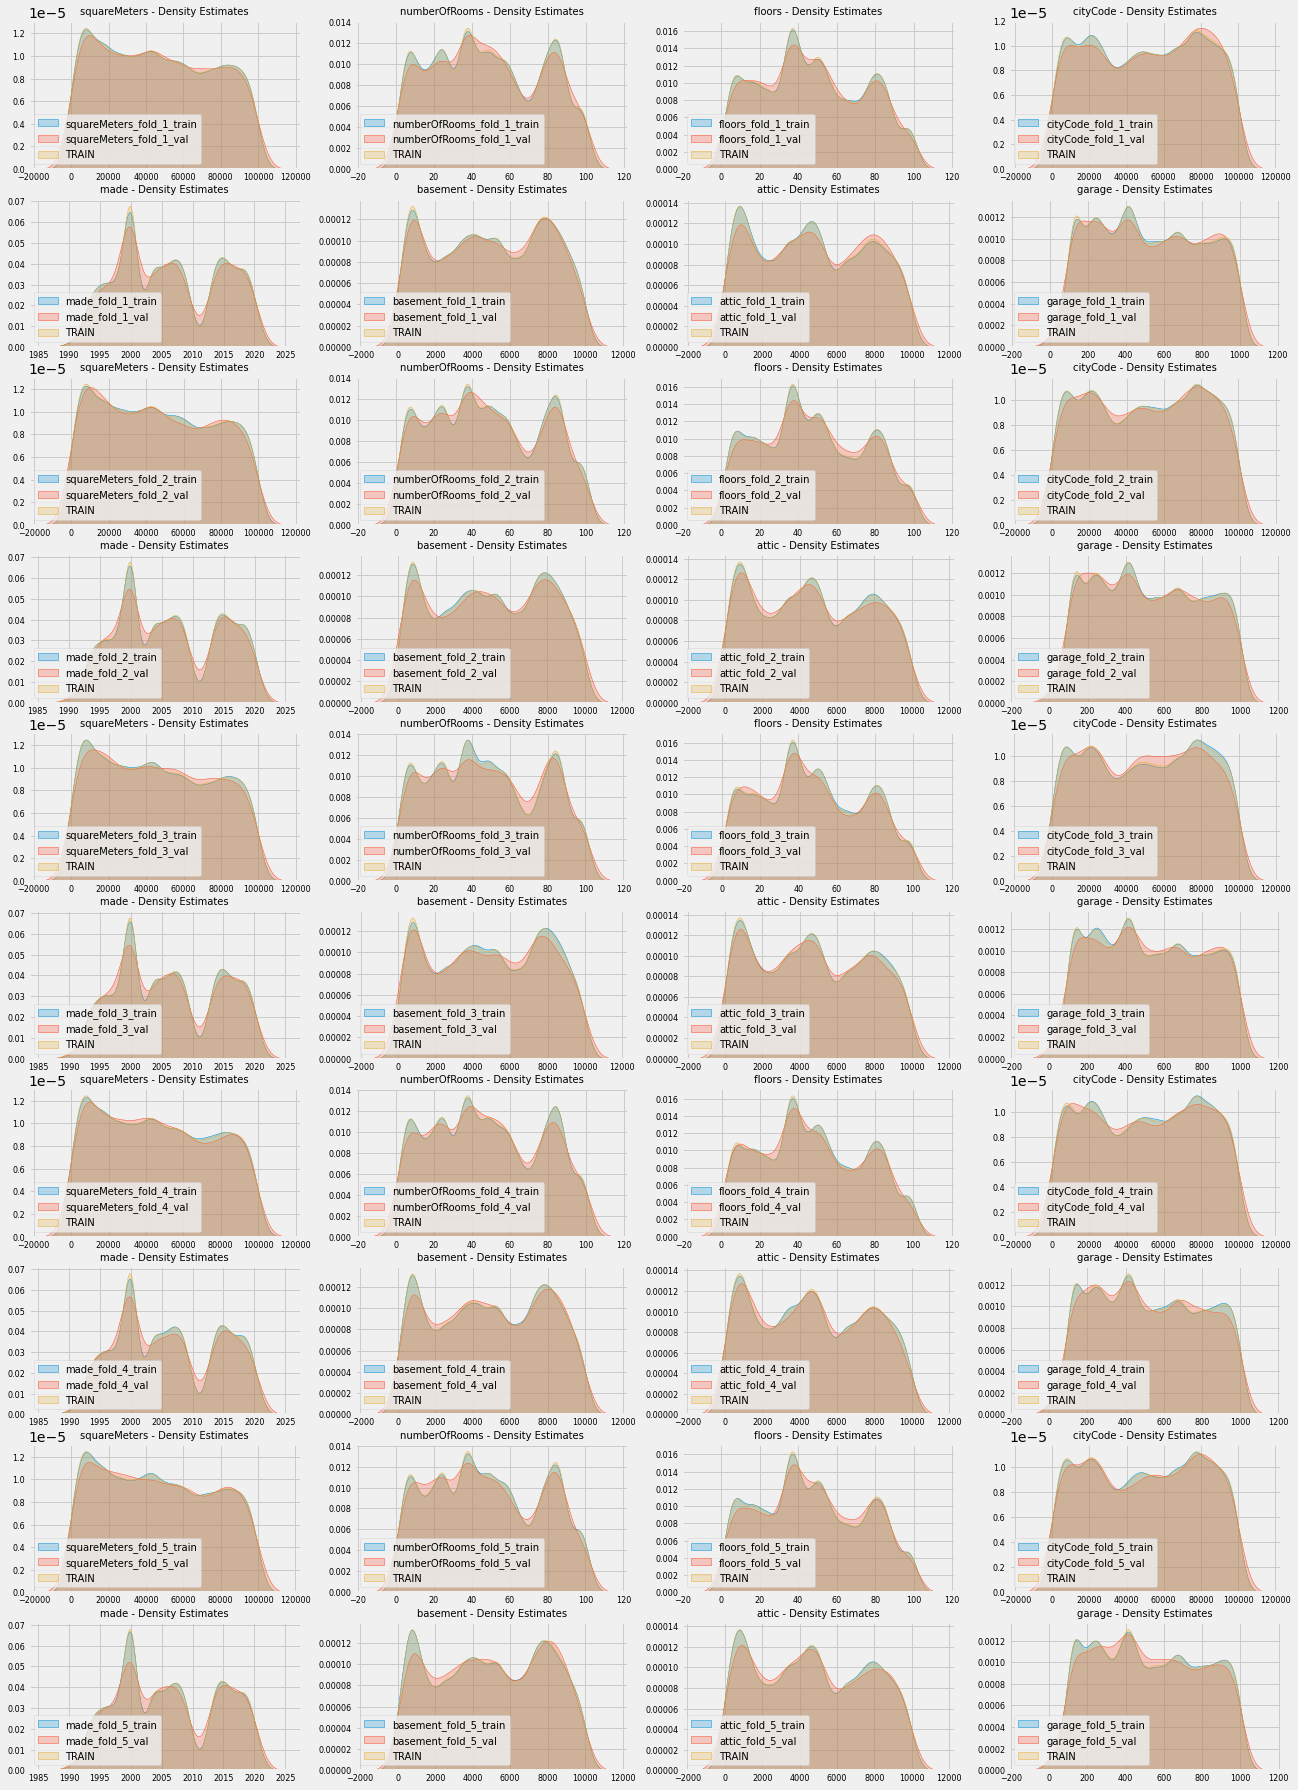

In [19]:
plt.style.use("fivethirtyeight")

fig, axs = plt.subplots(nrows=2*5, ncols=4, figsize=(20, 30))
axs = axs.flatten()

ax_counter = 0
for fold_num, fold_data in all_folds_datasets.items():
    for feat in numerical_features:
        _ = sns.kdeplot(fold_data["train"][feat], shade=True, label=f"{feat}_{fold_num}_train", ax=axs[ax_counter])
        _ = sns.kdeplot(fold_data["val"][feat], shade=True, label=f"{feat}_{fold_num}_val", ax=axs[ax_counter])
        _ = sns.kdeplot(train[feat], shade=True, label="TRAIN", ax=axs[ax_counter])
        
        _ = axs[ax_counter].set_title(f"{feat} - Density Estimates", fontsize=10)
        _ = axs[ax_counter].set_ylabel("")
        _ = axs[ax_counter].set_xlabel("")
        _ = axs[ax_counter].tick_params(axis='both', which='minor', labelsize=8)
        _ = axs[ax_counter].tick_params(axis='both', which='major', labelsize=8)

#         _ = axs[ax_counter].set_xticks(axs[ax_counter].get_xticks(), fontsize=5)
#         _ = axs[ax_counter].set_yticks(axs[ax_counter].get_yticks(), fontsize=5)
        
        
        handles, labels = axs[ax_counter].get_legend_handles_labels()
        axs[ax_counter].legend(handles=handles, labels=labels, title="", fontsize=10, loc="lower left")
        
        ax_counter += 1

## Insights:
1. The distribution of features of training sets for all folds matches closes with the full training set.
2. The distribution curve for Validation sets of all folds diverges from those of fold training set and overall training set BUT that phenomena is similar for all folds so that shouldn't cause such drastic change in scores like we see for fold 2 and fold 4.
3. And if you think categorical features might be the cause, well no, i already checked them in another notebook and they have pretty much the same distribution curves.

#### So what's the cause of such drastic differences in scores then?
The only feature that remains is the target feature. So it has to be the culprit.

Let's investigate!

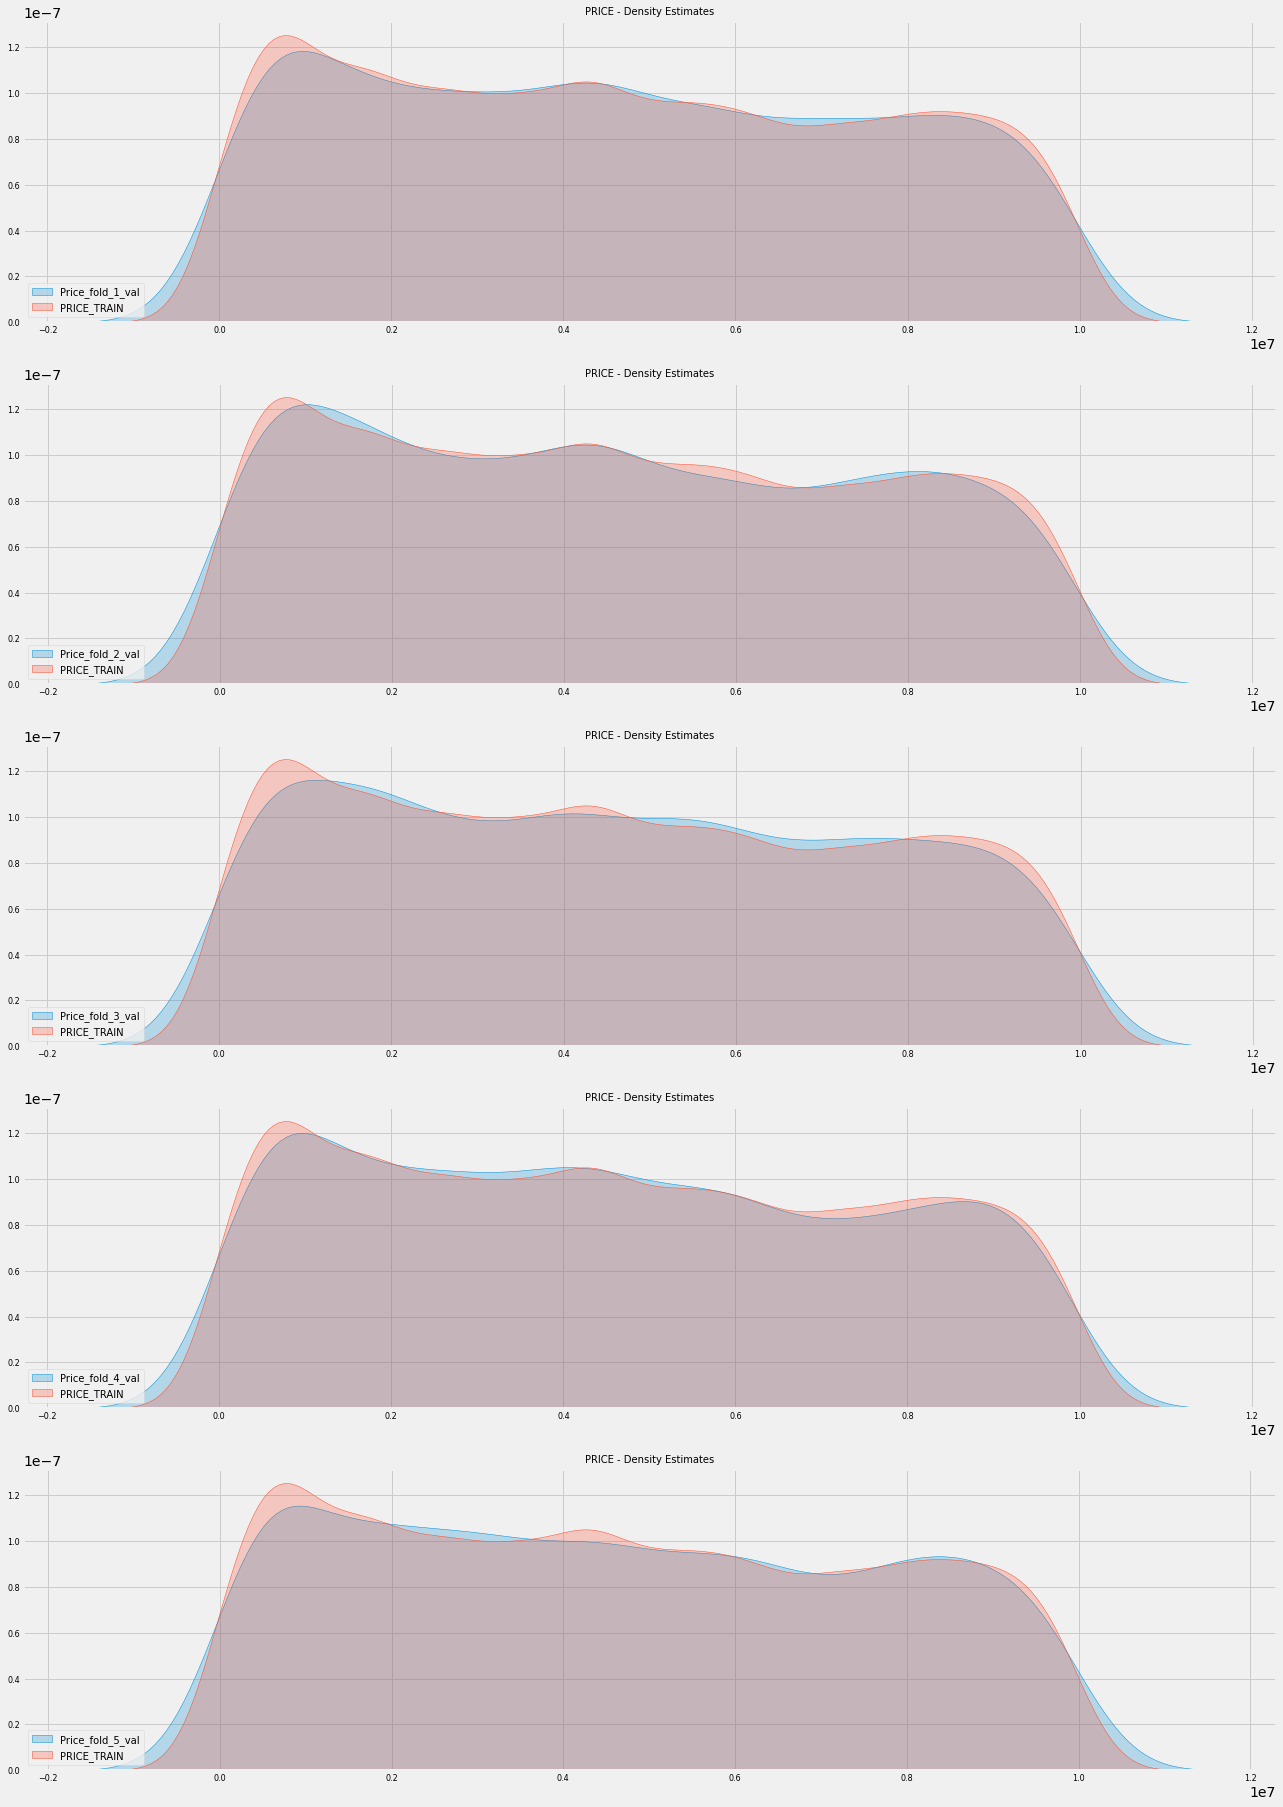

In [24]:
plt.style.use("fivethirtyeight")

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(20, 30))
axs = axs.flatten()

ax_counter = 0
for fold_num, fold_data in all_folds_datasets.items():
#     _ = sns.kdeplot(fold_data["train_target"], shade=True, label=f"Price_{fold_num}_train", ax=axs[ax_counter])
    _ = sns.kdeplot(fold_data["val_target"], shade=True, label=f"Price_{fold_num}_val", ax=axs[ax_counter])
    _ = sns.kdeplot(train.price, shade=True, label="PRICE_TRAIN", ax=axs[ax_counter])

    _ = axs[ax_counter].set_title(f"PRICE - Density Estimates", fontsize=10)
    _ = axs[ax_counter].set_ylabel("")
    _ = axs[ax_counter].set_xlabel("")
    _ = axs[ax_counter].tick_params(axis='both', which='minor', labelsize=8)
    _ = axs[ax_counter].tick_params(axis='both', which='major', labelsize=8)

#         _ = axs[ax_counter].set_xticks(axs[ax_counter].get_xticks(), fontsize=5)
#         _ = axs[ax_counter].set_yticks(axs[ax_counter].get_yticks(), fontsize=5)


    handles, labels = axs[ax_counter].get_legend_handles_labels()
    axs[ax_counter].legend(handles=handles, labels=labels, title="", fontsize=10, loc="lower left")

    ax_counter += 1